In [232]:
import os
import sys
# CaLRepo = os.environ.get("CaLRepo")
CaLRepo ='/home/anoldfriend/Workspace/MyRepo/thermodynamics/CaL'
# print(CaLRepo)
sys.path.append(f"{CaLRepo}/utilities/")
from pyPinch import PyPinch
import numpy as np
import pandas as pd
import proplot as pplot
import matplotlib.pyplot as plt
import json


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## results 
1. hot and cold composite curves
2. grand composite curve 
3. electric power consumption and power percentage
4. component investment cost and investment percentage
5. calciner side layout 
6. carbonator layout 

## comparisons 
1. carbonator heat recovery efficiency 
2. total heat recovery efficiency 
3. mass flow rate of hot water 
4. seperation efficiency 

## 1. HTCW=1, HRCP=0, obj=energy

In [236]:
cycle = pplot.Cycle("seaborn").by_key()['color']
with open("./results_HTCW=1HRCP=0_energy.json","r") as fp:
    results10energy=json.load(fp)
pa_text=results10energy["plant"]["carb"]["pinch_analysis_text"]
pinch = PyPinch(pa_text)
options = {}
pinch.solve(options)
compositeDiagram=pinch.compositeDiagram
grandCompositeCurve=pinch.grandCompositeCurve

with pplot.rc.context({'lines.linewidth': 2,"axes.labelsize":12,"tick.labelsize":11,
    "lines.marker":"o","lines.markersize":4,"legend.fontsize":14,"grid":False}):
    fig, axs = pplot.subplots(aspect=(4, 3), axwidth=4,ncols=2, nrows=1, share=False)
    axs[0].plot(compositeDiagram['hot']['H'], compositeDiagram['hot']['T'],color=cycle[2],label="hot streams")
    axs[0].plot(compositeDiagram['cold']['H'], compositeDiagram['cold']['T'],color=cycle[0],label="cold streams")
    axs[0].format(xlabel="thermal flux (kW)",ylabel="temperature ($^o$C)")
    axs[0].legend(loc="best", ncols=1, fancybox=True)

    axs[1].plot(grandCompositeCurve['H'], grandCompositeCurve['T'])
    axs[1].format(xlabel="thermal flux (kW)",ylabel="temperature ($^o$C)",xlim=[0, grandCompositeCurve['H'][-1]*1.1])
    
    # fig.savefig("compositeDiagram.jpg", bbox_inches='tight')

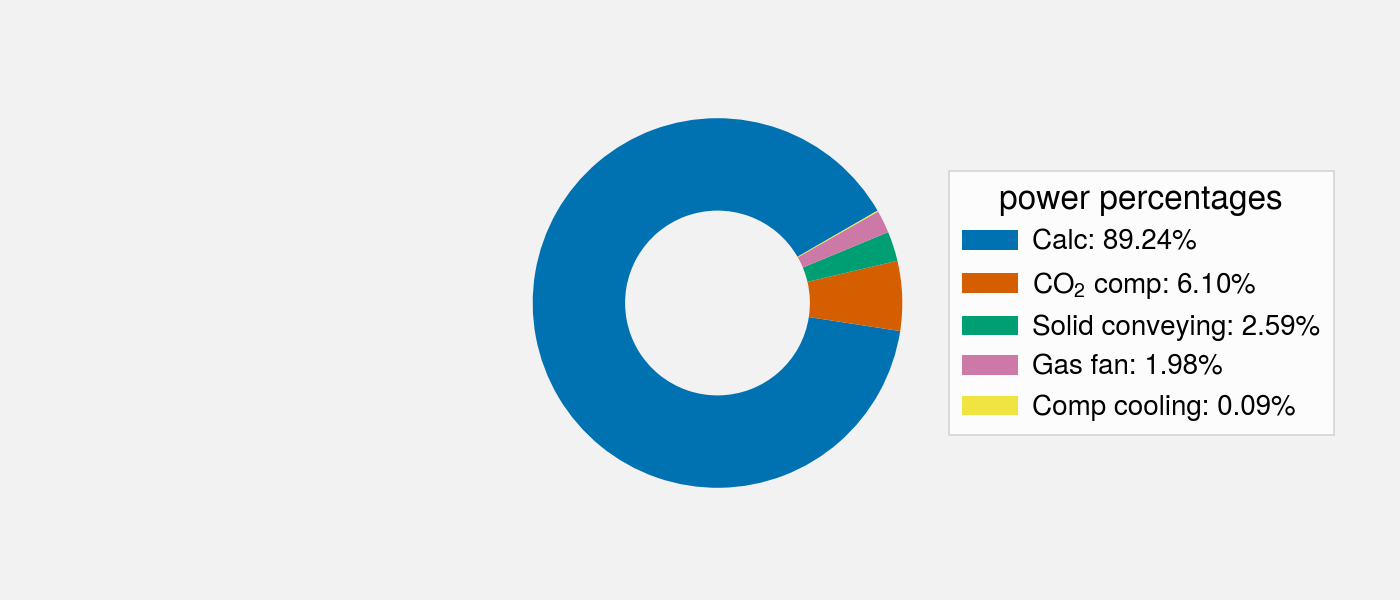

In [228]:
powers={}
plant_results=results10energy["plant"]
powers["Calc"]=plant_results["calc"]["We_calc"]
powers["CO2 comp"]=plant_results["calc"]["CO2_compression_train"]["compressor_power"]*(-1)
powers["Solid conveying"]=plant_results["calc"]["conveying_power"]*(-1)- \
    plant_results["carb"]["conveying_power"]
powers["Gas fan"]=plant_results["carb"]["flue_gas_fan_power"]*(-1)
powers["Comp cooling"]=plant_results["calc"]["CO2_compression_train"]["cooling_power"]*(-1)

data=list(powers.values())
percentages=list(np.array(data)/np.sum(data))
labels= list(powers.keys())
for i,label in enumerate(labels):
    if label.startswith("CO2"):
        label=label.replace("CO2","CO$_{2}$")
        labels[i]=label

labelAndPercentage=[ f"{label}: {percentages[i]*100:.2f}%" for i,label in enumerate(labels)]

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(percentages, wedgeprops=dict(width=0.5), startangle=30)

legend=ax.legend(wedges, labelAndPercentage,
          title="power percentages",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=10)
legend.get_title().set_fontsize('12')
fig.savefig("power_percentage.jpg", bbox_inches='tight')

# with pplot.rc.context({'lines.linewidth': 2,"axes.labelsize":12,"tick.labelsize":11,
#     "lines.marker":"o","lines.markersize":4,"legend.fontsize":14,"grid":False}):
#     fig, axs = pplot.subplots(aspect=(4, 3), axwidth=4)
#     indexs=np.arange(0,len(data))
#     axs.bar(np.array(data)/1e6, width=0.7, negpos=True, edgecolor='k')
#     axs.set_xticks(ticks=indexs)
#     axs.set_xticklabels(labels=labels,rotation=30)
#     axs.format(ylabel="power (MW)")

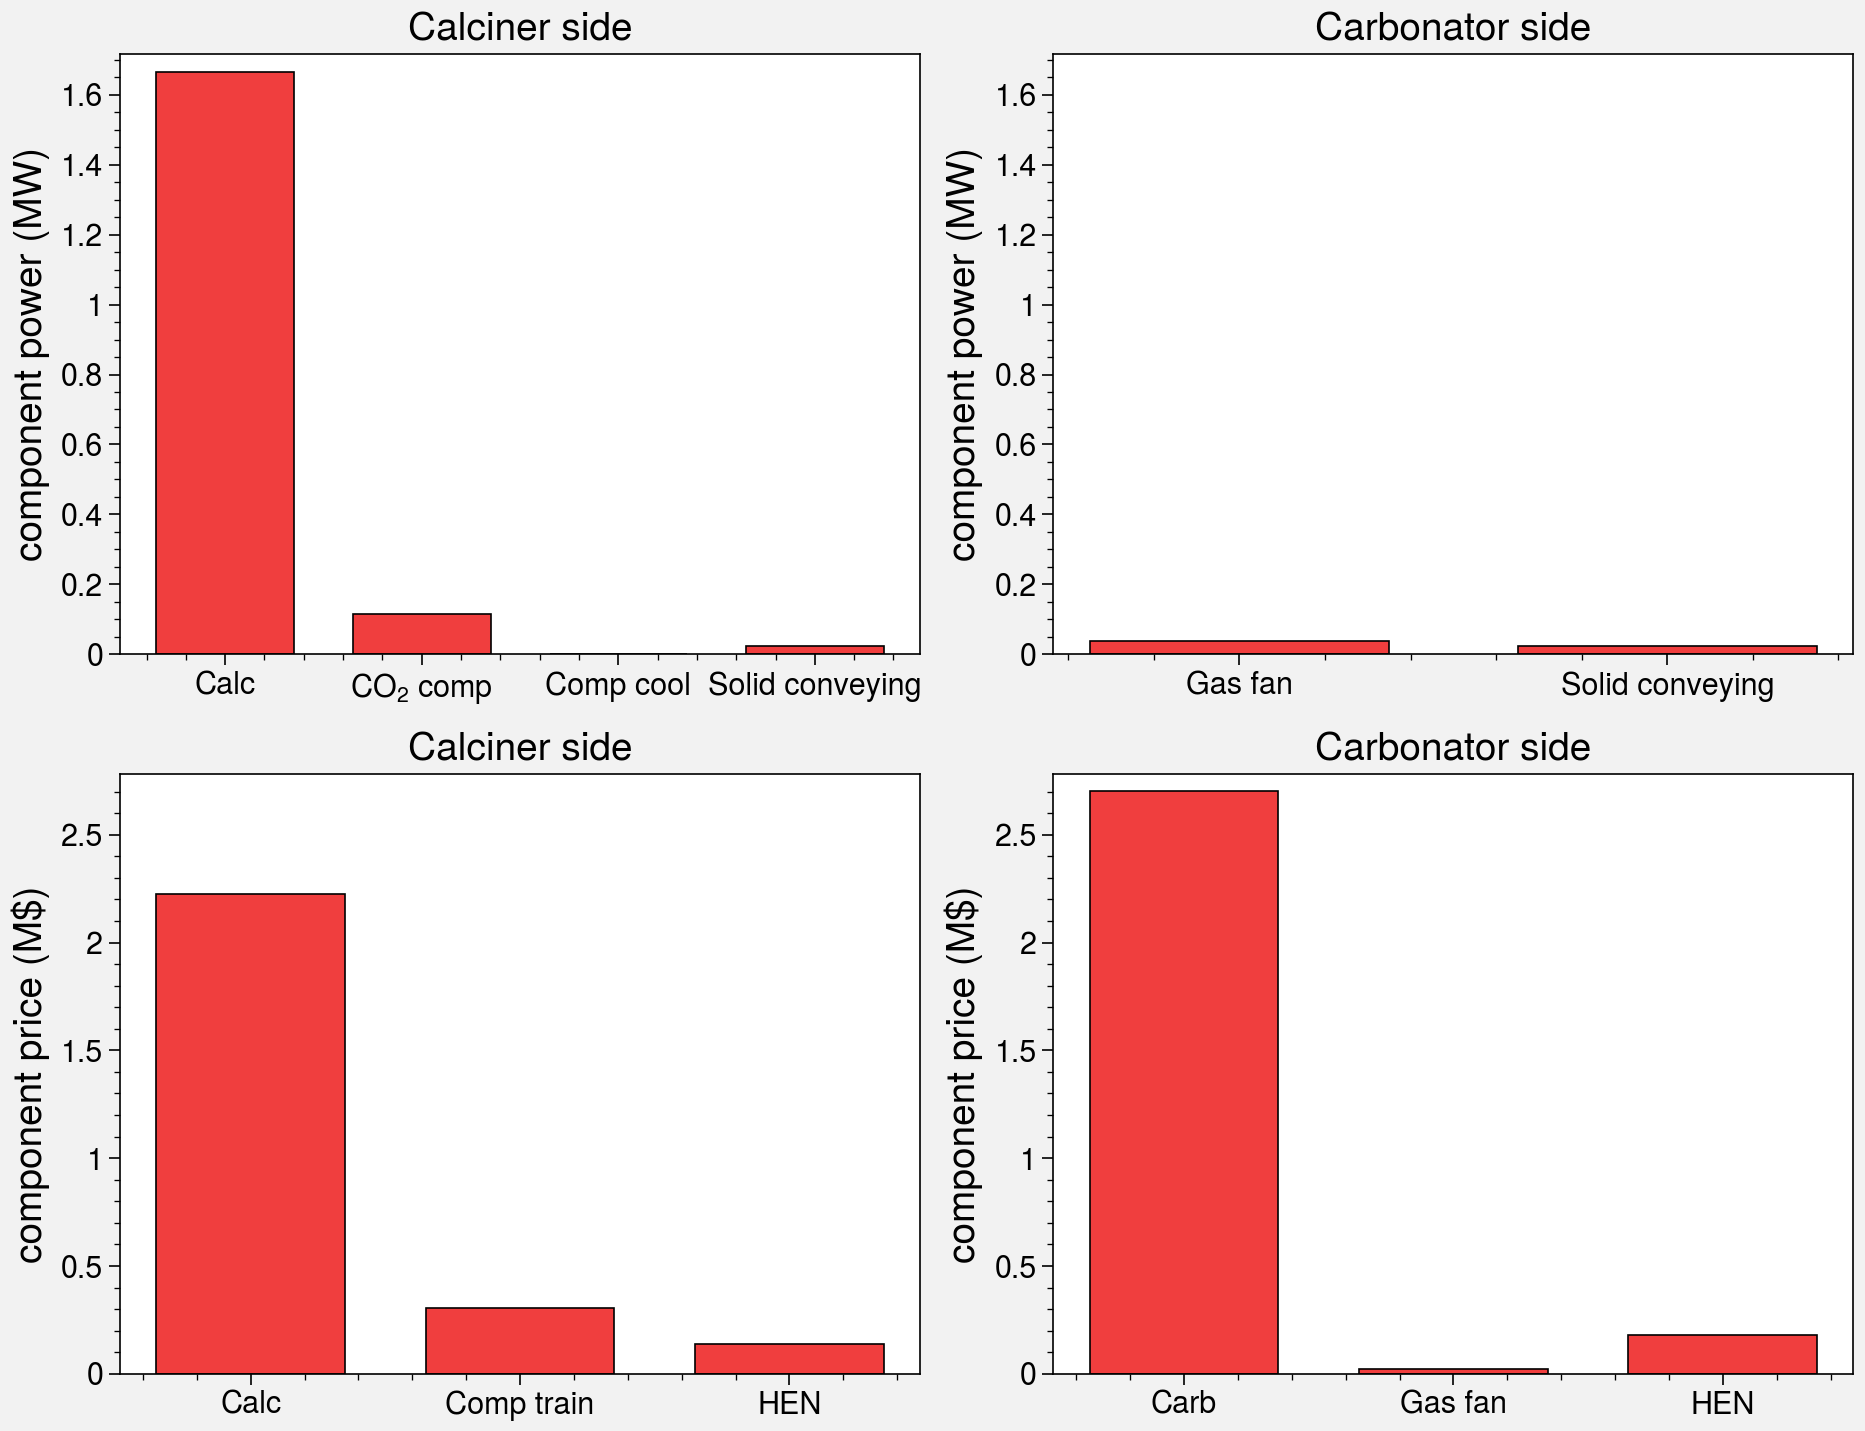

In [226]:
calc_power_labels=["Calc","CO$_{2}$ comp", "Comp cool","Solid conveying"]
calc_results=plant_results["calc"]
calc_powers=[calc_results["We_calc"],calc_results["CO2_compression_train"]["compressor_power"]*(-1),
            calc_results["CO2_compression_train"]["cooling_power"]*(-1),calc_results["conveying_power"]*(-1)]

carb_powers=plant_results["carb"]
carb_power_labels=["Gas fan", "Solid conveying"]
carb_powers=[carb_powers["flue_gas_fan_power"]*(-1),carb_powers["conveying_power"]*(-1)]
max_power=max(np.max(calc_powers)/1e6,np.max(carb_powers)/1e6)

calc_cost_labels=["Calc","Comp train", "HEN"]
economics=results10energy["metrics"]["economic"]
calc_costs=[economics["Ccalc"],economics["CCO2ct"],economics["CHENCalc"]]
carb_cost_labels=["Carb","Gas fan","HEN"]
carb_costs=[economics["Ccarb"],economics["CFF"],economics["CHENCarb"]]
max_cost=max(np.max(calc_costs),np.max(carb_costs))

rotation=0
with pplot.rc.context({'lines.linewidth': 2,"lines.marker":"o","lines.markersize":4,"legend.fontsize":14,"axes.titlesize":14,"grid":False}):
    fig, axs = pplot.subplots(aspect=(4, 3), axwidth=4,ncols=2, nrows=2, share=False)

    indexs0=np.arange(0,len(calc_powers))
    axs[0].bar(np.array(calc_powers)/1e6, width=0.7, negpos=True, edgecolor='k')
    axs[0].set_xticks(ticks=indexs0)
    axs[0].set_xticklabels(labels=calc_power_labels,rotation=rotation)
    axs[0].format(ylim=[0,max_power*1.03],title="Calciner side")
    axs[0].set_ylabel(ylabel="component power (MW)",fontsize=14)

    indexs1=np.arange(0,len(carb_powers))
    axs[1].bar(np.array(carb_powers)/1e6, width=0.7, negpos=True, edgecolor='k')
    axs[1].set_xticks(ticks=indexs1)
    axs[1].set_xticklabels(labels=carb_power_labels,rotation=rotation)
    axs[1].format(ylim=[0,max_power*1.03],title="Carbonator side")
    axs[1].set_ylabel(ylabel="component power (MW)",fontsize=14)

    indexs2=np.arange(0,len(calc_costs))
    axs[2].bar(calc_costs, width=0.7, negpos=True, edgecolor='k')
    axs[2].set_xticks(ticks=indexs2)
    axs[2].set_xticklabels(labels=calc_cost_labels,rotation=rotation)
    axs[2].format(ylim=[0,max_cost*1.03],title="Calciner side")
    axs[2].set_ylabel(ylabel="component price (M$)",fontsize=14)

    indexs3=np.arange(0,len(carb_costs))
    axs[3].bar(carb_costs, width=0.7, negpos=True, edgecolor='k')
    axs[3].set_xticks(ticks=indexs3)
    axs[3].set_xticklabels(labels=carb_cost_labels,rotation=rotation)
    axs[3].format(ylim=[0,max_cost*1.03],title="Carbonator side")
    axs[3].set_ylabel(ylabel="component price (M$)",fontsize=14)

    fig.savefig("power_costs.jpg", bbox_inches='tight')

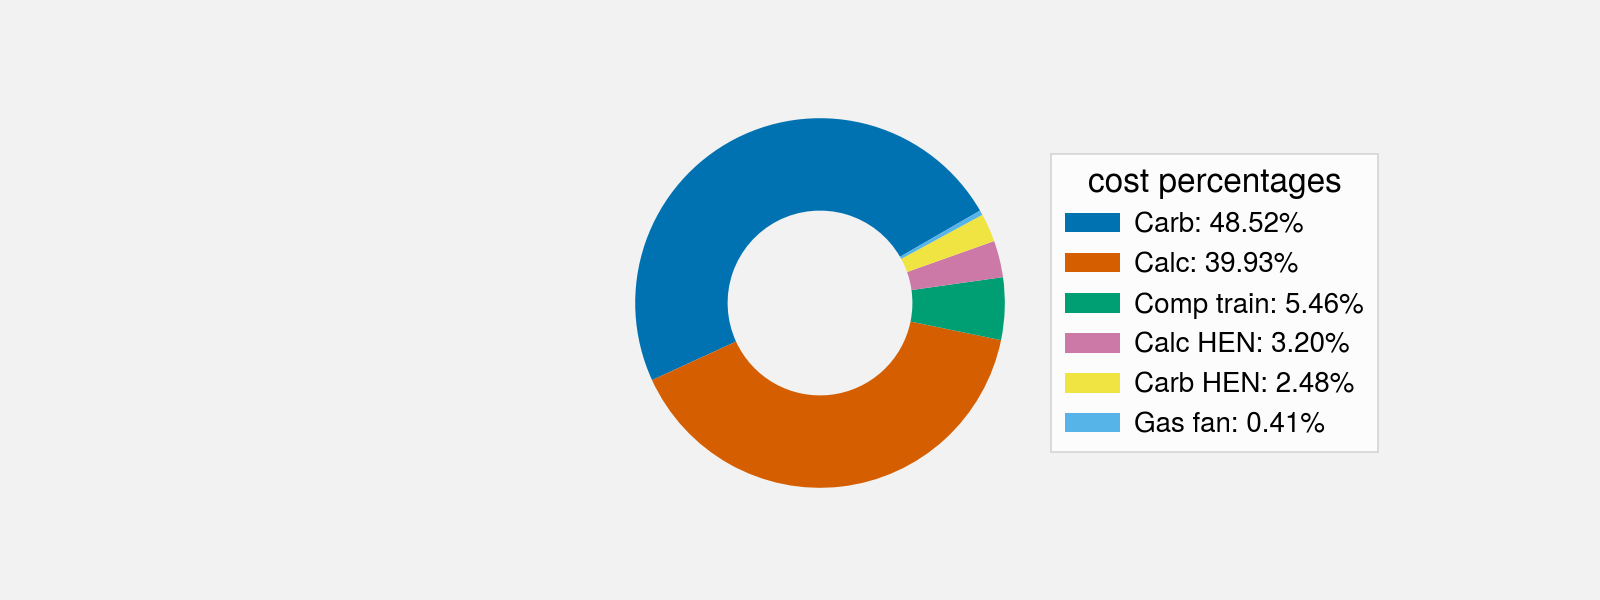

In [231]:
all_labels=[]
all_costs=[]
for i,cost in enumerate(carb_costs):
    label=carb_cost_labels[i]
    if label=="HEN":
        label="Calc HEN"
    all_labels.append(label)
    all_costs.append(cost)
for i,cost in enumerate(calc_costs):
    label=calc_cost_labels[i]
    if label=="HEN":
        label="Carb HEN"
    all_labels.append(label)
    all_costs.append(cost)
costs={}
costs["component"]=all_labels
costs["costs"]=all_costs

df_costs=pd.DataFrame(costs)
df_costs.sort_values(by="costs",inplace=True,ascending=False)
df_costs=df_costs.reset_index(drop=True)
df_costs.head(6)


data=list(df_costs["costs"])
percentages=list(np.array(data)/np.sum(data))
labels= list(df_costs["component"])
for i,label in enumerate(labels):
    if label.startswith("CO2"):
        label=label.replace("CO2","CO$_{2}$")
        labels[i]=label

labelAndPercentage=[ f"{label}: {percentages[i]*100:.2f}%" for i,label in enumerate(labels)]

fig, ax = plt.subplots(figsize=(8, 3), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(percentages, wedgeprops=dict(width=0.5), startangle=30)

legend=ax.legend(wedges, labelAndPercentage,
          title="cost percentages",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=10)
legend.get_title().set_fontsize('12')
fig.savefig("price_percentage.jpg", bbox_inches='tight')
